# 1. Imports

In [2]:
# general imports
import pandas as pd
import numpy as np
import random
import os
from natsort import os_sorted
import time
import json
import math

# tf and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from keras.layers import BatchNormalization
from keras import models
from keras import layers
from keras import metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
tf.get_logger().setLevel('INFO')

# pretrained iamge models
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

# plots
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
%matplotlib inline
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image

# random seeds
random.seed(1234)
tf.random.set_seed(1234)
np.random.seed(1234)

# 2. Key variables

In [229]:
# primary image folder - using the augmented data set
IMAGE_PATH = r'C:\Users\jscot\OneDrive\Documents\data\Plant Leaf Diseases\Plant_leaf_diseases_dataset_with_augmentation\Plant_leave_diseases_dataset_with_augmentation'

# default settings for image processing/learning/data augmentation
CONTRAST_FACTOR = 2
DELTA = 0.1
LEARNING_RATE = 0.001
IMG_SIZE = (256, 256)
MAX_IMGS = 1000

# dictionary of {folder_name:readable_name}
class_names = {'Tomato___healthy':'Healthy', 
                'Tomato___Bacterial_spot':'Bacterial spot', 
                'Tomato___Early_blight':'Early blight', 
                'Tomato___Late_blight':'Late blight', 
                'Tomato___Leaf_Mold':'Leaf Mold', 
                'Tomato___Septoria_leaf_spot':'Septoria leaf spot', 
                'Tomato___Spider_mites Two-spotted_spider_mite':'Spider mites', 
                'Tomato___Target_Spot':'Target Spot', 
                'Tomato___Tomato_mosaic_virus':'Mosaic virus', 
                'Tomato___Tomato_Yellow_Leaf_Curl_Virus':'Yellow Leaf Curl virus'
                }

# 3. Mapping & Initial data display

Total Classes: 10
Total Images: 10000
Sample of images in data:


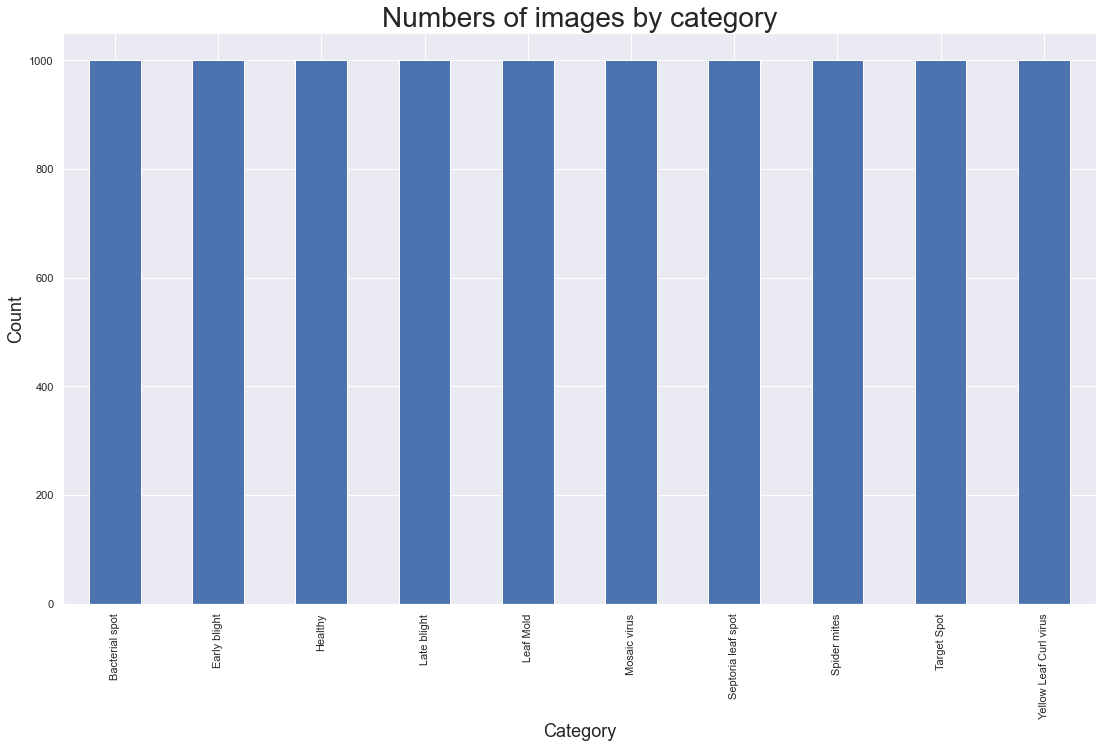

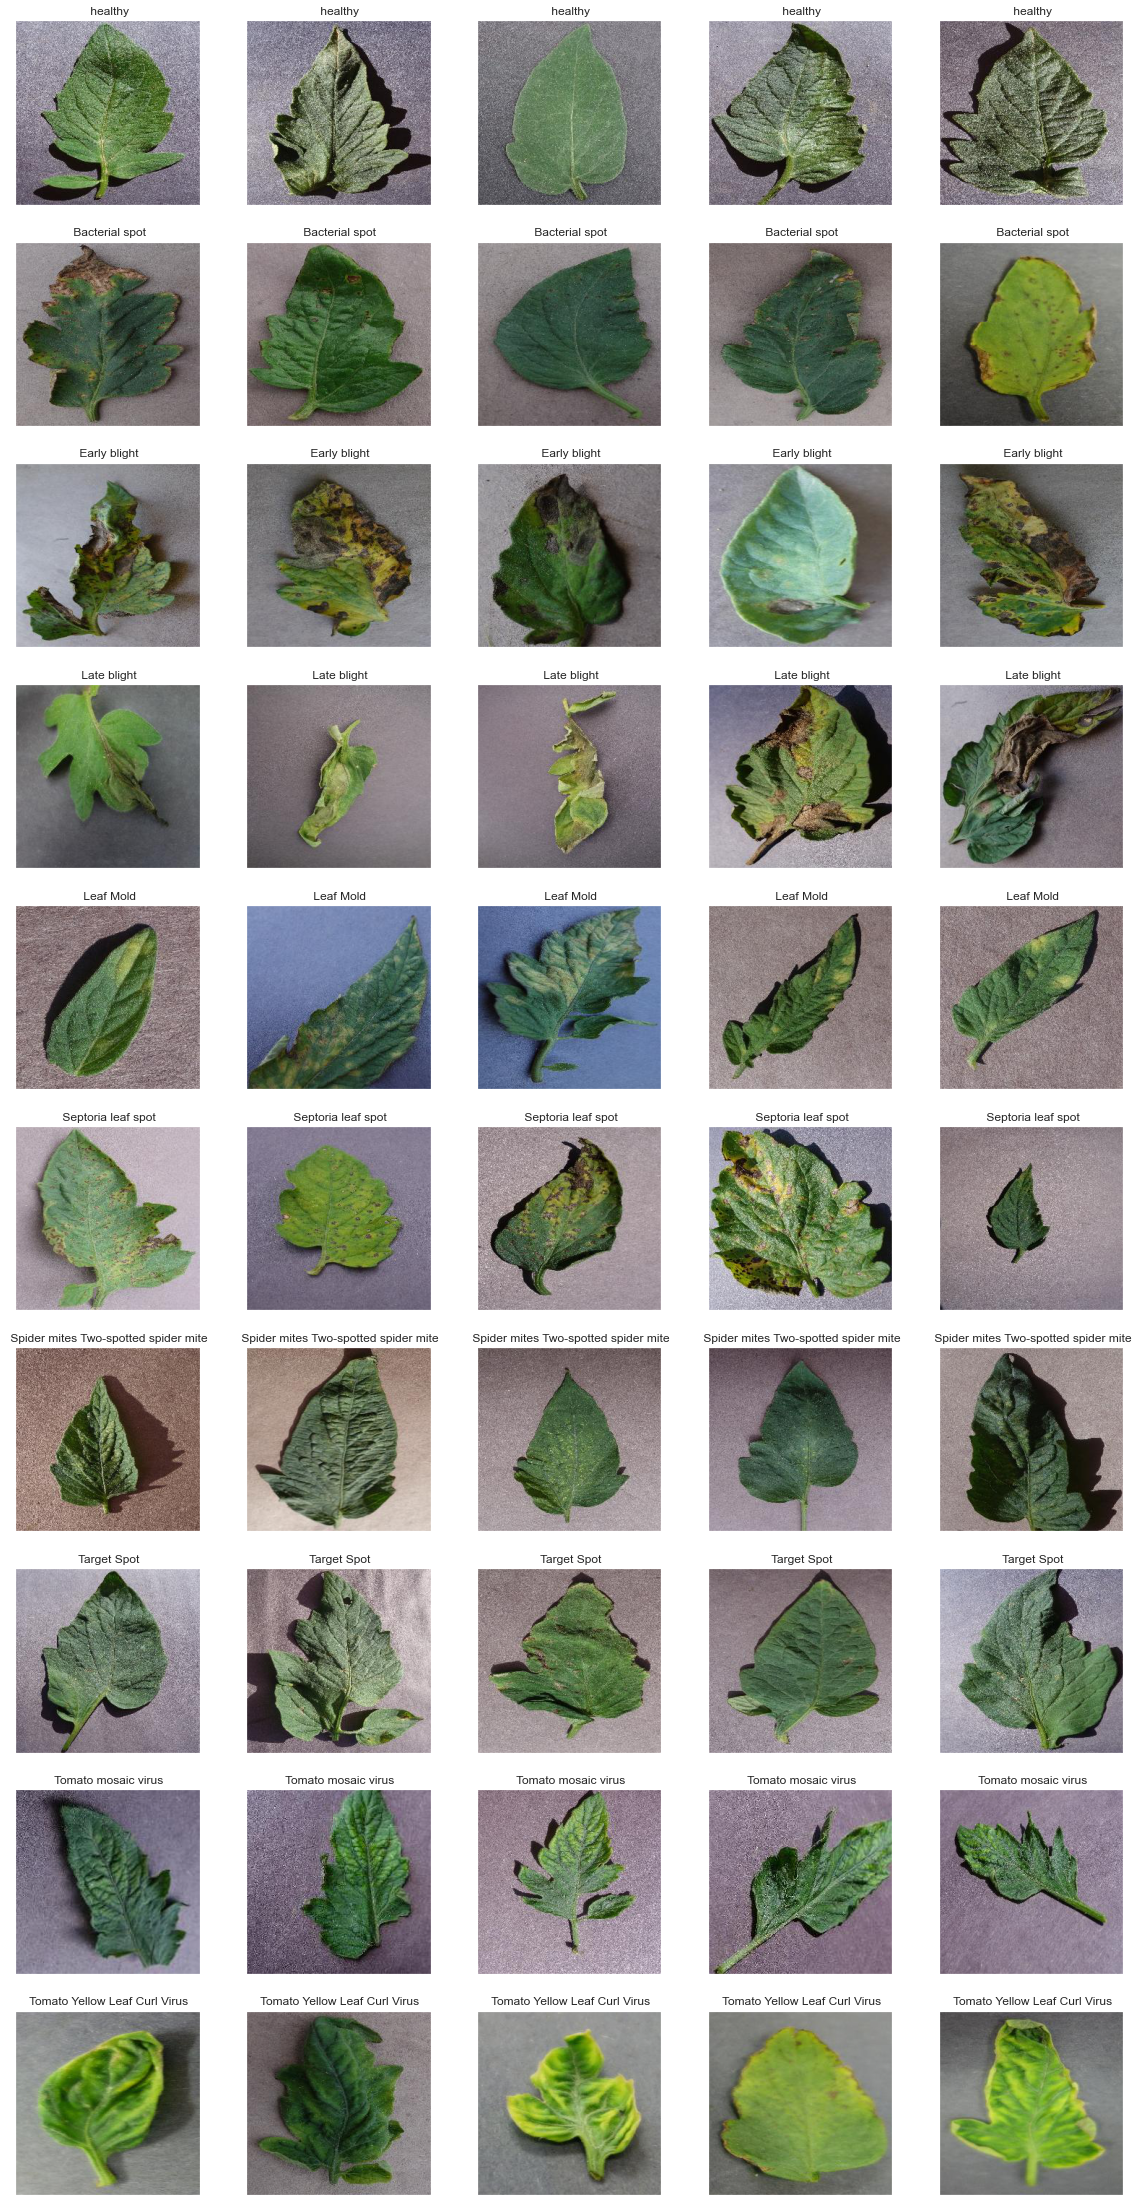

In [237]:
def get_leaf_mapping(img_fol, class_names, max_imgs=10000, to_show=False):
    """Create a mapping of image paths and image label.
    
    Args:
        img_fol: string path to folder of image-label folders 
        class_names: dictionary of {exact_folder_name:pretty name}
        max_imgs: the max number of images that will be loaded for each label 
        to_show: whether a bar chart of the counts of each label should be shown 

    Returns:
        model: a dataframe of file paths, classes, and class names.
    """

    columns=['file_path','class','class_name']
    mapping = pd.DataFrame(columns=columns)

    for class_num, class_name in enumerate(class_names):
        class_loc = os.path.join(img_fol, class_name)
        files = [os.path.join(class_loc, item) for item in os_sorted(os.listdir(os.path.join(img_fol, class_name)))]
        random.shuffle(files)
        mapping = pd.concat([mapping, pd.DataFrame({'file_path':files[:max_imgs], 'class':class_num, 'class_name':class_names[class_name]})])
    mapping.reset_index(drop=True, inplace=True)

    print(f'Total Classes: {len(class_names)}\nTotal Images: {len(mapping)}')
    if to_show:
        histy = mapping.loc[:,'class_name'].value_counts().sort_index().plot.bar()
        ax = plt.gca()
        ax.set_title('Numbers of images by category', fontsize=28)
        ax.set_xlabel('Category', fontsize=18)
        ax.set_ylabel('Count', fontsize=18)
        plt.gcf().set_size_inches(18.5, 10.5)

    return mapping

def show_class_examples(mapping, to_show=5):
    """Show examples of each class.
    
    Args:
        mapping: mapping produced by "get_leaf_mapping"; a dataframe of paths, numerical labels, and pretty labels
        to_show: number of each image class to show

    Returns:
        f: figure of the example plot
        axs: axes of the example plot
    """
    indx=0
    imgs = []
    print('Sample of images in data:')

    for class_num in mapping.loc[:,'class'].unique():
        classes = mapping[mapping.loc[:,'class']==class_num].head(to_show)
        
        for img_num, row in classes.iterrows():
            imgs.append(load_img(row[0]))

    nrows, ncols = len(class_names), to_show
    f, axs = plt.subplots(nrows, ncols, figsize=(20,40))

    for i in range(nrows):
        for j in range(ncols):
            indx = i*ncols+j
            axs[i,j].imshow(imgs[indx])
            axs[i,j].grid(None)
            axs[i,j].xaxis.set_visible(False)
            axs[i,j].yaxis.set_visible(False)
            axs[i,j].set_title(list(class_names)[i].split('__')[1].replace('_', ' '))
    return f, axs

# Get mapping and show class examples
mapping = get_leaf_mapping(IMAGE_PATH, class_names, max_imgs=MAX_IMGS, to_show=True)
fig, axes = show_class_examples(mapping, to_show=5)

# 4. Functions for loading data and processing neural networks

In [4]:
def load_and_split(mapping, split=(0.7,0.1,0.2), img_size=IMG_SIZE, flip=True):
    """Load randomized/augmented data, and split into train/valid/test groups.
    
    Args:
        mapping: mapping produced by "get_leaf_mapping"; a dataframe of paths, numerical labels, and pretty labels
        split: (train_proportion, validation_proportion, test_proportion), should sum to 1.0
        img_size: 2-tuple of image sizes to be used to prepare data
        flip: whether images should be flipped horizontally during data augmentation process

    Returns:
        X_train, y_train, X_val, y_val, X_test, y_test <-- self-explanatory!
    """
    
    y = []
    images = []
    for idx, row in enumerate(mapping.iterrows()):
        img = load_img(
            row[1][0],
            target_size=img_size)
        img = img_to_array(img)
        images.append(img)
        y.append(row[1][1])

    images = np.stack(images)
    y = np.array(y).flatten()

    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]
    
    splits = np.multiply(len(images), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])
    X_train = tf.image.resize(X_train, size=img_size)
    X_val = tf.image.resize(X_val, size=img_size)
    X_test = tf.image.resize(X_test, size=img_size)
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    if flip:
        X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array

    return X_train, y_train, X_val, y_val, X_test, y_test

def model_from_structure(structure, img_size=IMG_SIZE):
    """Create and compile a keras model from short-hand way of describing neural network structure.  
    
    Args:
        structure: list of lists that define a neural network
            (allows for simple logistic, feed-forward, convolutional, and transfer-learning based models)
        img_size: 2-tuple of image sizes to be used to prepare data

    Returns:
        model: a compiled keras model of a neural network
    """
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()
    for num, layer in enumerate(structure):
        if layer[0] == 'conv':
            model.add(tf.keras.layers.Conv2D(
                        filters=layer[3],
                        kernel_size=(layer[1], layer[1]),
                        strides=(layer[2], layer[2]),
                        padding='same',
                        data_format='channels_last',
                        name=str(num),
                        activation='relu'))
        elif layer[0] == 'VGG16':
            base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
            base_model.trainable = False ## Not trainable weights
            model.add(base_model)
        elif layer[0] == 'VGG19':
            base_model = VGG19(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
            base_model.trainable = False ## Not trainable weights
            model.add(base_model)
        elif layer[0] == 'max_pool':
            model.add(tf.keras.layers.MaxPool2D(
                        pool_size=(layer[1], layer[1]),
                        name=str(num))) 
        elif layer[0] == 'flatten':
            model.add(tf.keras.layers.Flatten())
        elif layer[0] == 'batch_norm':
            model.add(BatchNormalization())
        elif layer[0] == 'dense':
            model.add(tf.keras.layers.Dense(
                        units=layer[1],
                        name=str(num),
                        activation='relu'))
        elif layer[0] == 'dropout':
            model.add(tf.keras.layers.Dropout(
                        rate=0.5))
        elif layer[0] == 'output':
            model.add(tf.keras.layers.Dense(
                        units=layer[1],
                        name='output',
                        activation=None))
    
    model.build(input_shape=(None, img_size[0], img_size[1], 3))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) 
    return model

def fit_and_eval_model(model, X_train, y_train, X_val, y_val, batch_size=125, epochs=5):
    """Take a compiled keras model and fit to training data, comparing to validation data.  
    
    Args:
        model: compiled keras model
        X_train, y_train, X_val, y_val <-- self-explanatory
        batch_size: number of images to be included in each batch of processing
        epochs: number of epochs to run

    Returns:
        hist: model training history
        training_time: time in seconds that the model took to run
    """
    training_time = time.perf_counter()
    history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val))
    hist = history.history
    print(f"Final training accuracy: {hist['accuracy'][-1]}")
    print(f"Final validation accuracy: {hist['val_accuracy'][-1]}")
    training_time = time.perf_counter() - training_time
    return hist, training_time

def final_test(model, X_test, y_test):
    """Run a fitted model with final test data"""
    test_results = model.evaluate(X_test, y_test)
    print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))
    return test_results

def save_as_json(training_info, loc=r'C:\Users\jscot\OneDrive\Documents\school\W207\project\data.json'):
    """"Save training data as JSON"""
    with open(loc, 'w', encoding='utf-16') as f:
        json.dump(training_info, f, ensure_ascii=False, indent=4)

def run_training(training_info, NN_structure, img_size, epochs=5, train_val=None):
    """Perform a single run of training a neural net and report the results.  
    
    Args:
        training_info: list of results of previous training, to which this training will be appended
        NN_structure: dictionary of neural structure definition
        img_size: size of images (2-tuple)
        epochs: number of epochs to run
        train_val: 4-tuple of (X_train, y_train, X_val, y_val)

    Returns:
        training_info: congoing list of results of training events 
        train_val: 4-tuple of (X_train, y_train, X_val, y_val), to be used in subsequent training evnts
    """
    if train_val is None:
        X_train, y_train, X_val, y_val, _, _ = load_and_split(mapping, 
                                                                split=(0.7,0.1,0.2), 
                                                                img_size=img_size, 
                                                                flip=True)
    else:
        X_train, y_train, X_val, y_val = train_val
    model = model_from_structure(NN_structure, img_size=img_size)
    display(model.summary())
    hist, training_time = fit_and_eval_model(model, X_train, y_train, X_val, y_val, epochs=epochs)

    training_dict = {
        'NN_structure':NN_structure,
        'img_size':img_size,
        'epochs':epochs,
        'hist':hist,
        'training_time':training_time
    }
    train_val = (X_train, y_train, X_val, y_val)
    training_info.append(training_dict)
    return training_info, train_val

def run_training2(training_info, NN_structure, img_size, epochs=5, train_val=None):
    """Same as run_training, but ALSO saves model in training_info dictionary"""
    if train_val is None:
        X_train, y_train, X_val, y_val, _, _ = load_and_split(mapping, 
                                                                split=(0.7,0.1,0.2), 
                                                                img_size=img_size, 
                                                                flip=True)
    else:
        X_train, y_train, X_val, y_val = train_val
    model = model_from_structure(NN_structure, img_size=img_size)
    display(model.summary())
    hist, training_time = fit_and_eval_model(model, X_train, y_train, X_val, y_val, epochs=epochs)

    training_dict = {
        'NN_structure':NN_structure,
        'img_size':img_size,
        'epochs':epochs,
        'hist':hist,
        'training_time':training_time,
        'model':model
    }
    train_val = (X_train, y_train, X_val, y_val)
    training_info.append(training_dict)
    return training_info, train_val

def run_NNs(NNs, name, save_json=False):
    """Perform a sequence of neural net training runs, recording all results.  
    
    Args:
        NNs: list of Neural Network training events to run
        name: name used to save the information

    Returns:
        training_info: congoing list of results of training events 
        train_val: 4-tuple of (X_train, y_train, X_val, y_val), to be used in subsequent training evnts
    """
    training_info = []
    train_val = None
    
    run_training_func = run_training if save_json else run_training2

    for NN_num, NN, in enumerate(NNs):
        print(NN_num, NN)
        try:
            if train_val and train_val[0].shape[1] == NN['img_size']:
                training_info, train_val = run_training_func(training_info, NN['NN_structure'], NN['img_size'], epochs=NN['epochs'], train_val=train_val)
            else:
                del train_val
                training_info, train_val = run_training_func(training_info, NN['NN_structure'], NN['img_size'], epochs=NN['epochs'])

        except:
            print(f'failed on {NN_num}')
            if save_json:
                save_as_json(training_info, loc=rf'C:\Users\jscot\OneDrive\Documents\school\W207\project\data_{name}_up_to_{NN_num}.json')
            return
    print(training_info)
    if save_json:
        save_as_json(training_info, loc=rf'C:\Users\jscot\OneDrive\Documents\school\W207\project\data_{name}_complete.json')

    return training_info

# 3a. Logistic Models

### Using five different image sizes

In [5]:
img_heights = [256, 128, 64, 32, 16]

logistic_NNs = [{'NN_structure':[['flatten'],
                    ['output', len(class_names)]],
    'img_size':(img_height, img_height),
    'epochs':10} for img_height in img_heights]

# logistic_results = run_NNs(logistic_NNs, 'logistic_NNs')
# logistic_results

# 3b. Feed-forward models

### Different neuron and layer counts

1-layer FF NNs -->

In [6]:
dense_sizes = [2048, 1024, 512]
img_heights = [256, 128, 64]

FF_1layer_NNs = [{'NN_structure':[['flatten'],
                    ['dense', dense_size],
                    ['output', len(class_names)]],
    'img_size':(img_height, img_height),
    'epochs':10} for dense_size in dense_sizes for img_height in img_heights]

# FF_1layer_NN_results = run_NNs(FF_1layer_NNs, 'FF_1layer_NNs')

2-layer FF NNs -->

In [7]:
dense_layers = [[2048, 128], [512, 32]]
img_heights = [256, 128, 64]

FF_2layer_NNs = [{'NN_structure':[['flatten'],
                    ['dense', denses[0]],
                    ['dense', denses[1]],
                    ['output', len(class_names)]],
    'img_size':(img_height, img_height),
    'epochs':5} for img_height in img_heights for denses in dense_layers]

# FF_2layer_NN_results = run_NNs(FF_2layer_NNs, 'FF_2layer_NNs')

3-layer FF NNs -->

In [8]:
dense_layers = [[2048, 512, 64], [1024, 512, 64], [1024, 256, 64], [1024, 256, 32], [512, 128, 32]]
img_heights = [128, 64]

FF_3layer_NNs = [
    {'NN_structure':[['flatten'],
                    ['dense', denses[0]],
                    ['dense', denses[1]],
                    ['dense', denses[2]],
                    ['output', len(class_names)]],
    'img_size':(img_height, img_height),
    'epochs':5} for img_height in img_heights for denses in dense_layers]

# FF_3layer_NN_results = run_NNs(FF_3layer_NNs, 'FF_3layer_NNs')  

4-layer FF NNs -->

In [9]:
dense_layers_init_sizes = [1024, 512, 256]
img_heights = [128, 64]

FF_4layer_NNs = [
    {'NN_structure':[['flatten'],
                    ['dense', init],
                    ['dense', init/2],
                    ['dense', init/4],
                    ['dense', init/8],
                    ['output', len(class_names)]],
    'img_size':(img_height, img_height),
    'epochs':10} for img_height in img_heights for init in dense_layers_init_sizes]\

# FF_4layer_NN_results = run_NNs(FF_4layer_NNs, 'FF_4layer_NNs')

# 2c. Simple CNNs

### (1/2 Conv layers) x (1/2 FF layers) 

1 conv, 1 FF -->

In [10]:
convs = [9, 5]
strides = [1, 2]
denses = [512, 256]
img_sizes = [128, 64]
filters = [64, 32]

CNN_1_1_layers = [{'NN_structure':[['conv', conv, stride, filter],
                    ['max_pool', 2],
                    ['flatten'],
                    ['dense', dense],
                    ['output', len(class_names)]],
    'img_size':(img_siz,img_siz),
    'epochs':5} for conv in convs for stride in strides for dense in denses for img_siz in img_sizes for filter in filters]

# CNN_1_1_layers_results = run_NNs(CNN_1_1_layers, 'CNN_1_1_layers')

In [11]:
CNN_1_1_layers = [
    {'NN_structure':[['conv', 7, 2, 32],
                    ['conv', 3, 1, 32],
                    ['flatten'],
                    ['dense', 512],
                    ['output', len(class_names)]],
    'img_size':(128,128),
    'epochs':5},

    {'NN_structure':[['conv', 7, 2, 32],
                    ['conv', 3, 1, 32],
                    ['max_pool', 2],
                    ['flatten'],
                    ['dense', 512],
                    ['output', len(class_names)]],
    'img_size':(128,128),
    'epochs':5},
    
    {'NN_structure':[['conv', 7, 2, 32],
                    ['max_pool', 2],
                    ['conv', 3, 1, 32],
                    ['max_pool', 2],
                    ['flatten'],
                    ['dense', 512],
                    ['output', len(class_names)]],
    'img_size':(128,128),
    'epochs':5}
]

# CNN_1_1_layers_results_max_pool_or_not = run_NNs(CNN_1_1_layers, 'CNN_1_1_layers_max_pool_or_not')

1 conv, 2 FF -->

In [13]:
convs = [7, 5]
strides = [1, 2]
denses1 = [512]
denses2 = [128]
img_sizes = [64]
filters = [32]

CNN_1_2_layers = [{'NN_structure':[
                    ['conv', conv, stride, filter],
                    ['max_pool', 2],
                    ['flatten'],
                    ['dense', dense1],
                    ['dense', dense2],
                    ['output', len(class_names)]],
                'img_size':(img_siz,img_siz),
                'epochs':5} for conv in convs
                            for stride in strides 
                            for dense1 in denses1 
                            for dense2 in denses2
                            for img_siz in img_sizes 
                            for filter in filters]

# CNN_1_2_layers_results = run_NNs(CNN_1_2_layers, 'CNN_1_2_layers')

2 conv, 1 FF -->

In [14]:
convs1 = [9]
convs2 = [5]
strides = [2]
denses = [1024, 512, 256]
img_sizes = [128]
filters = [64]
epochs = [10]

CNN_2_1_layers = [{'NN_structure':[
                    ['conv', conv1, stride, filter],
                    ['max_pool', 2],
                    ['conv', conv2, stride, filter],
                    ['max_pool', 2],
                    ['flatten'],
                    ['dense', dense],
                    ['output', len(class_names)]],
                'img_size':(img_siz,img_siz),
                'epochs':epoch} for conv1 in convs1
                            for conv2 in convs2
                            for stride in strides 
                            for dense in denses
                            for img_siz in img_sizes 
                            for filter in filters
                            for epoch in epochs]

# CNN_2_1_layers_results = run_NNs(CNN_2_1_layers, 'CNN_2_1_layers')

# df = pd.DataFrame({'val_acc':[thing['hist']['val_accuracy'][-1] for thing in CNN_2_2_layers_results],
#                 'conv1':[thing['NN_structure'][0] for thing in CNN_2_2_layers_results],
#                 'conv1':[thing['NN_structure'][1] for thing in CNN_2_2_layers_results],
#                 'dense':[thing['NN_structure'][4][1] for thing in CNN_2_2_layers_results],
#                 'dense':[thing['NN_structure'][4][1] for thing in CNN_2_2_layers_results],
#                 'img_size':[thing['img_size'][0] for thing in CNN_2_2_layers_results],
#                 'training_time':[thing['training_time'] for thing in CNN_2_2_layers_results]
#                 }).to_clipboard()

In [15]:
CNN_2_1_dropout_layers = [
    {'NN_structure':[['conv', 9, 1, 32],
                    ['max_pool', 2],
                    ['conv', 5, 1, 32],
                    ['max_pool', 2],
                    ['flatten'],
                    ['dense', 1024],
                    ['dropout', 0.5],
                    ['output', len(class_names)]],
    'img_size':(128,128),
    'epochs':10},

    {'NN_structure':[['conv', 9, 1, 32],
                    ['max_pool', 2],
                    ['conv', 5, 1, 32],
                    ['max_pool', 2],
                    ['flatten'],
                    ['dense', 1024],
                    ['dropout', 0.25],
                    ['output', len(class_names)]],
    'img_size':(128,128),
    'epochs':10}
]

# CNN_2_1_dropout_layers = run_NNs(CNN_2_1_dropout_layers, 'CNN_2_1_dropout_layers')

2 conv, 2 FF -->

In [16]:
convs1 = [7]
convs2 = [3]
strides = [1]
denses1 = [512]
denses2 = [128]
img_sizes = [128]
filters = [64]

CNN_2_2_layers = [{'NN_structure':[
                    ['conv', conv1, stride, filter],
                    ['max_pool', 2],
                    ['conv', conv2, stride, filter],
                    ['max_pool', 2],
                    ['flatten'],
                    ['dense', dense1],
                    ['dropout', 0.25],
                    ['dense', dense2],
                    ['dropout', 0.25],
                    ['output', len(class_names)]],
                'img_size':(img_siz,img_siz),
                'epochs':10} for conv1 in convs1
                            for conv2 in convs2
                            for stride in strides 
                            for dense1 in denses1 
                            for dense2 in denses2
                            for img_siz in img_sizes 
                            for filter in filters]

# CNN_2_2_layers_results = run_NNs(CNN_2_2_layers, 'CNN_2_2_layers')

In [17]:
convs1 = [9, 7]
convs2 = [7, 5]
strides = [2]
denses1 = [1024]
denses2 = [256]
img_sizes = [128]
filters = [64]
epochs = [10]

# convs1 = [5]
# convs2 = [3]
# strides = [2]
# denses1 = [256]
# denses2 = [64]
# img_sizes = [64]
# filters = [64]
# epochs = [5]

CNN_2_2_layers = [{'NN_structure':[
                    ['conv', conv1, stride, filter],
                    ['max_pool', 2],
                    ['conv', conv2, stride, filter],
                    ['max_pool', 2],
                    ['flatten'],
                    ['dense', dense1],
                    ['dense', dense2],
                    ['output', len(class_names)]],
                'img_size':(img_siz,img_siz),
                'epochs':epoch} for conv1 in convs1
                            for conv2 in convs2
                            for stride in strides 
                            for dense1 in denses1 
                            for dense2 in denses2
                            for img_siz in img_sizes 
                            for filter in filters
                            for epoch in epochs]

# CNN_2_2_layers_results = run_NNs(CNN_2_2_layers, 'CNN_2_2_layers_128_higher_dense_convs')

# df = pd.DataFrame({'val_acc':[thing['hist']['val_accuracy'][-1] for thing in CNN_2_2_layers_results],
#                 'conv1':[thing['NN_structure'][0] for thing in CNN_2_2_layers_results],
#                 'conv1':[thing['NN_structure'][1] for thing in CNN_2_2_layers_results],
#                 'dense':[thing['NN_structure'][4][1] for thing in CNN_2_2_layers_results],
#                 'dense':[thing['NN_structure'][4][1] for thing in CNN_2_2_layers_results],
#                 'img_size':[thing['img_size'][0] for thing in CNN_2_2_layers_results],
#                 'training_time':[thing['training_time'] for thing in CNN_2_2_layers_results]
#                 }).to_clipboard()

# 2d. Smaller hand-made AlexNet
## "AlexNiet"
#### (smaller numbers of FF neurons)

In [18]:
alex_layers = [
    {'NN_structure':[['conv', 11, 4, 96],
                    ['max_pool', 3],
                    ['conv', 5, 1, 256],
                    ['max_pool', 3],
                    ['conv', 3, 1, 384],
                    ['conv', 3, 1, 384],
                    ['conv', 3, 1, 384],
                    ['max_pool', 3],
                    ['flatten'],
                    ['dropout', 0.5],
                    ['dense', 1024],
                    ['dropout', 0.5],
                    ['dense', 1024],
                    ['output', len(class_names)]],
    'img_size':(256,256),
    'epochs':10},
]

# alex_results = run_NNs(alex_layers, 'alex_net')

# 2e. Transfer Learning with VGG16 and VGG19 (imagenet training)

### Final layers removed and re-trained

VGG16 with (128, 128) imgs and 5 epochs; 512 dense layer then 64 dense layer -->

In [19]:
def run_vgg16_1():# load data
    X_train, y_train, X_val, y_val, _, _ = load_and_split(mapping, split=(0.7,0.1,0.2), 
                                                                    img_size=(128, 128), 
                                                                    flip=True)

    ## Loading VGG16 model
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
    base_model.trainable = False ## Not trainable weights

    ## Preprocessing input
    train_ds = preprocess_input(X_train) 
    val_ds = preprocess_input(X_val)
    test_ds = preprocess_input(X_val)

    flatten_layer = layers.Flatten()
    dense_layer_1 = layers.Dense(512, activation='relu')
    dense_layer_2 = layers.Dense(64, activation='relu')
    prediction_layer = layers.Dense(len(class_names), activation='softmax')

    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer_1,
        dense_layer_2,
        prediction_layer
    ])

    model.build(input_shape=(None, X_train[0].shape[0], X_train[0].shape[1], X_train[0].shape[2]))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy']) 

    es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

    training_time = time.perf_counter()
    history = model.fit(X_train, y_train, 
                    epochs=5, 
                    batch_size=100, 
                    callbacks=[es], 
                    validation_data=(X_val, y_val))
    hist = history.history
    training_time = time.perf_counter() - training_time
    model.summary()
    model.save(rf'C:\Users\jscot\OneDrive\Documents\school\W207\project\data_VGG16_512,64_complete.json')

# run_vgg16_1()

VGG19 with (64, 64) imgs and 5 epochs; 128 dense layer then 32 dense layer -->

In [20]:
def run_vgg19_small():
    X_train, y_train, X_val, y_val, _, _ = load_and_split(mapping, split=(0.7,0.1,0.2), 
                                                                img_size=(64, 64), 
                                                                flip=True)

    ## Loading VGG19 model
    base_model = VGG19(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
    base_model.trainable = False ## Not trainable weights

    ## Preprocessing input
    train_ds = preprocess_input(X_train) 
    val_ds = preprocess_input(X_val)
    test_ds = preprocess_input(X_val)

    flatten_layer = layers.Flatten()
    dense_layer_1 = layers.Dense(128, activation='relu')
    dense_layer_2 = layers.Dense(32, activation='relu')
    prediction_layer = layers.Dense(len(class_names), activation='softmax')

    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer_1,
        dense_layer_2,
        prediction_layer
    ])

    model.build(input_shape=(None, X_train[0].shape[0], X_train[0].shape[1], X_train[0].shape[2]))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy']) 

    es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

    training_time = time.perf_counter()
    history = model.fit(X_train, y_train, 
                    epochs=5, 
                    batch_size=100, 
                    callbacks=[es], 
                    validation_data=(X_val, y_val))
    hist = history.history
    training_time = time.perf_counter() - training_time
    model.summary()
    model.save(rf'C:\Users\jscot\OneDrive\Documents\school\W207\project\data_VGG19_128,32_complete.json')

# run_vgg19_small()

VGG19 with (256, 256) imgs and 8 epochs; 1024 dense layer then 256 dense layer -->

In [21]:
def run_vgg19_large():
    X_train, y_train, X_val, y_val, _, _ = load_and_split(mapping, split=(0.7,0.1,0.2), 
                                                                img_size=(256, 256), 
                                                                flip=True)

    ## Loading VGG19 model
    base_model = VGG19(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
    base_model.trainable = False ## Not trainable weights

    ## Preprocessing input
    train_ds = preprocess_input(X_train) 
    val_ds = preprocess_input(X_val)
    test_ds = preprocess_input(X_val)

    flatten_layer = layers.Flatten()
    dense_layer_1 = layers.Dense(1024, activation='relu')
    dense_layer_2 = layers.Dense(256, activation='relu')
    prediction_layer = layers.Dense(len(class_names), activation='softmax')

    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer_1,
        dense_layer_2,
        prediction_layer
    ])

    model.build(input_shape=(None, X_train[0].shape[0], X_train[0].shape[1], X_train[0].shape[2]))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy']) 

    es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

    training_time = time.perf_counter()
    history = model.fit(X_train, y_train, 
                    epochs=8, 
                    batch_size=100, 
                    callbacks=[es], 
                    validation_data=(X_val, y_val))
    hist = history.history
    training_time = time.perf_counter() - training_time
    model.summary()
    model.save(rf'C:\Users\jscot\OneDrive\Documents\school\W207\project\data_VGG19_1024,256_complete.json')

# run_vgg19_large()

# 3. Comparisons of classifiers (training time vs validation performance)
#### Prep data from saved JSON files, then store as a dataframe with relevant info 

In [22]:
def compile_results_from_json(save_loc=r'C:\Users\jscot\OneDrive\Documents\school\W207\project\results_df.csv'):
    results_loc = Path(save_loc).parent
    print(results_loc)

    primary = {'logistic':'data_logistic_NNs_complete.json',
                'FF_1':'data_FF_1layer_NNs_complete.json',
                'FF_2':'data_FF_2layer_NNs_complete.json',
                'FF_3':'data_FF_3layer_NNs_complete.json',
                'FF_4':'data_FF_4layer_NNs_complete.json',
                'CNN_1_1':'data_CNN_1_1_layers_complete.json',
                'CNN_2_1':'data_CNN_2_1_layers_complete.json',
                'CNN_1_2':'data_CNN_1_2_layers_complete.json',
                'CNN_2_2':'data_CNN_2_2_layers_complete.json'
                }

    results_df = pd.DataFrame(columns=['type', 'name', 'epochs', 'nn_struct', 'img_size', 'final_train_acc', 'final_valid_acc', 'best_valid_acc', 'training_time'])

    # assemble data from JSONs to a df
    for nn_type, json_loc in primary.items():
        path = results_loc / json_loc
        print(nn_type, '----', path)
        
        with open(path, 'r', encoding='utf-16') as f:
            this_json = json.load(f)

            for nn_num, nn in enumerate(this_json):
                #print('\t', nn)
                results_df = pd.concat([results_df, pd.DataFrame([{'type':nn_type, 
                                                                'name':nn_num, 
                                                                'epochs':int(nn['epochs']),
                                                                'nn_struct':str(nn['NN_structure']), 
                                                                'img_size':int(nn['img_size'][0]), 
                                                                'final_train_acc':float(nn['hist']['accuracy'][-1]), 
                                                                'final_valid_acc':float(nn['hist']['val_accuracy'][-1]),
                                                                'best_valid_acc':float(max(nn['hist']['val_accuracy'])),
                                                                'training_time':float(nn['training_time'])/60
                                                                }])], ignore_index=True, axis=0)

    results_df.drop_duplicates(inplace=True)
    results_df.img_size = results_df.img_size.astype(int)
    results_df.to_csv(save_loc)

compile_results_from_json()

C:\Users\jscot\OneDrive\Documents\school\W207\project
logistic ---- C:\Users\jscot\OneDrive\Documents\school\W207\project\data_logistic_NNs_complete.json
FF_1 ---- C:\Users\jscot\OneDrive\Documents\school\W207\project\data_FF_1layer_NNs_complete.json
FF_2 ---- C:\Users\jscot\OneDrive\Documents\school\W207\project\data_FF_2layer_NNs_complete.json
FF_3 ---- C:\Users\jscot\OneDrive\Documents\school\W207\project\data_FF_3layer_NNs_complete.json
FF_4 ---- C:\Users\jscot\OneDrive\Documents\school\W207\project\data_FF_4layer_NNs_complete.json
CNN_1_1 ---- C:\Users\jscot\OneDrive\Documents\school\W207\project\data_CNN_1_1_layers_complete.json
CNN_2_1 ---- C:\Users\jscot\OneDrive\Documents\school\W207\project\data_CNN_2_1_layers_complete.json
CNN_1_2 ---- C:\Users\jscot\OneDrive\Documents\school\W207\project\data_CNN_1_2_layers_complete.json
CNN_2_2 ---- C:\Users\jscot\OneDrive\Documents\school\W207\project\data_CNN_2_2_layers_complete.json


In [9]:
def display_training_results(to_save=False, save_loc=r'C:\Users\jscot\OneDrive\Documents\school\W207\project\all_results.html'):
    # NOTE --> additional entries were hand-compiled and added to a saved "results_df_all.csv" file

    results_df_all = pd.read_csv(r'C:\Users\jscot\OneDrive\Documents\school\W207\project\results_df_all.csv')
    fig = px.scatter(results_df_all, 
                    x='training_time', 
                    y='final_valid_acc', 
                    hover_name="type", 
                    hover_data=["img_size", 'epochs', "nn_struct"], 
                    color='type', 
                    color_discrete_sequence=px.colors.qualitative.Light24,
                    size='img_size',
                    labels={
                        'final_valid_acc':'Validation Accuracy (%)',
                        'training_time':'Training Time (min)',
                        'type':'Network Type'
                    }
    )

    fig.update_layout(font=dict(family="Calibri",
                                size=18
                            ),
                        title={
                            'text': 'Performance vs training duration for different models',
                            'y':0.98,
                            'x':0.5,
                            'xanchor': 'center',
                            'yanchor': 'top',
                            'font':dict(
                                        family="Calibri",
                                        size=38
                                    )},
                            )

    # NOTE -->Save the model
    if to_save:
        fig.write_html(save_loc)
    
    fig.show()
display_training_results(to_save=True)

# 4. Ensemble of fast-training models

### Combine five of the models that have:
1. Different structures
2. Validation accuracies > 0.8
3. Training Times < 3 minutes

In [24]:
def train_ensemble(to_save=False, save_loc=rf'C:\Users\jscot\OneDrive\Documents\school\W207\project'):
    img_size = (64, 64)
    path = Path(save_loc)

    ensemble_NNs = [
        {'NN_structure':[['conv', 7, 1, 32], ['max_pool', 2], ['conv', 3, 1, 32], ['max_pool', 2], ['flatten'], ['dense', 512], ['dense', 64], ['output', len(class_names)]],
        'img_size':img_size,
        'epochs':10},

        {'NN_structure':[['conv', 5, 2, 32], ['conv', 3, 2, 32], ['max_pool', 2], ['flatten'], ['dense', 256], ['dense', 64], ['output', len(class_names)]],
        'img_size':img_size,
        'epochs':20},

        {'NN_structure':[['conv', 5, 1, 32], ['max_pool', 2], ['flatten'], ['dense', 512], ['output', len(class_names)]],
        'img_size':img_size,
        'epochs':5},

        {'NN_structure':[['conv', 5, 2, 64], ['max_pool', 2], ['flatten'], ['dense', 256], ['output', len(class_names)]],
        'img_size':img_size,
        'epochs':5},

        {'NN_structure':[['conv', 5, 2, 32], ['conv', 3, 2, 32], ['max_pool', 2], ['flatten'], ['dense', 256], ['dense', 64], ['output', len(class_names)]],
        'img_size':img_size,
        'epochs':5},
    ]

    ensemble_NNs_results = [NN['model'] for NN in run_NNs(ensemble_NNs, 'ensemble_NNs', save_json=False)]

    if to_save:
        for nn_num, nn in enumerate(ensemble_NNs_results):
            print(nn_num, nn, '\n')
            nn.save(path / f'ensemble {nn_num}')

    return ensemble_NNs_results

def load_ensmeble_models(model_loc=rf'C:\Users\jscot\OneDrive\Documents\school\W207\project'):
    path = Path(model_loc)
    models = []
    for nn_num in range(5):
        models.append(keras.models.load_model(path / f'ensemble {nn_num}'))
    return models

ensemble_models = load_ensmeble_models() 

In [25]:
# Load all data again, according to the split
# This time, use only the ensemble of small models
# therefore, image size is (64,64)
X_train, y_train, X_val, y_val, X_test, y_test = load_and_split(mapping, split=(0.7,0.1,0.2), 
                                                                img_size=(64, 64), 
                                                                flip=True)

In [48]:
def get_ensemble_characterization_results(ensemble_models_list):
    results = {
        'preds_list': [],
        'confusion_list': [],
        'tp_list':[],
        'fp_list':[],
        'fn_list':[],
        'tn_list':[],
        'precision_list':[],
        'recall_list':[],
        'precision_np':None,
        'ensemble_decisions':None
    }
    
    for nn_num, nn in enumerate(ensemble_models_list):
        test_predictions = np.argmax(nn.predict(X_test), axis=-1)
        
        # Create a confusion matrix as a 2D array
        confusion_matrix = tf.math.confusion_matrix(y_test, test_predictions)
        
        tp = np.diag(confusion_matrix)
        fp = np.array([(sum(confusion_matrix[:,i]) - confusion_matrix[i,i]).numpy() for i in range(len(tp))])
        fn = np.array([(sum(confusion_matrix[i,:]) - confusion_matrix[i,i]).numpy() for i in range(len(tp))])
        tn = np.array([sum(sum(confusion_matrix)) - sum(confusion_matrix[:,i]) - sum(confusion_matrix[i,:]) + confusion_matrix[i,i] for i in range(len(tp))])

        precision = (tp / (tp + fp)).round(3)
        recall = (tp / (tp + fn)).round(3)

        # print(f'''tp: {tp}\nfp: {fp}\nfn: {fn}\ntn: {tn}\n\nprecision: {precision}\nrecall: {recall}''')

        results['preds_list'].append(test_predictions)
        results['confusion_list'].append(confusion_matrix)
        results['tp_list'].append(tp)
        results['fp_list'].append(fp)
        results['fn_list'].append(fn)
        results['tn_list'].append(tn)
        results['precision_list'].append(precision)
        results['recall_list'].append(recall)

    totals = np.zeros(shape=(X_test.shape[0], len(list(class_names))))

    for nn_num, nn in enumerate(ensemble_models_list):
        # print(nn_num)
        preds = nn.predict(X_test)
        totals = totals + preds

    ensemble_preds = totals/len(ensemble_models_list)
    ensemble_decisions = ensemble_preds.argmax(axis=1)
    confusion_matrix = tf.math.confusion_matrix(y_test, ensemble_decisions)

    tp = np.diag(confusion_matrix)
    fp = np.array([(sum(confusion_matrix[:,i]) - confusion_matrix[i,i]).numpy() for i in range(len(tp))])
    fn = np.array([(sum(confusion_matrix[i,:]) - confusion_matrix[i,i]).numpy() for i in range(len(tp))])
    tn = np.array([sum(sum(confusion_matrix)) - sum(confusion_matrix[:,i]) - sum(confusion_matrix[i,:]) + confusion_matrix[i,i] for i in range(len(tp))])

    precision = (tp / (tp + fp)).round(3)
    recall = (tp / (tp + fn)).round(3)

    results['preds_list'].append(test_predictions)
    results['confusion_list'].append(confusion_matrix)
    results['tp_list'].append(tp)
    results['fp_list'].append(fp)
    results['fn_list'].append(fn)
    results['tn_list'].append(tn)
    results['precision_list'].append(precision)
    results['recall_list'].append(recall)

    precision_np = np.zeros((len(results['precision_list']), len(class_names)))
    for i_num, i in enumerate(results['precision_list']):
        precision_np[i_num,:] = i

    results['precision_np']=precision_np
    results['ensemble_decisions']=ensemble_decisions

    return results

def show_failures(confusion_np):
    diag = np.diag(np.diag(confusion_np))
    failures = confusion_np - diag
    ax = sns.heatmap(failures, annot=True, fmt='.3g', cmap='Blues',
                xticklabels=[val for key, val in class_names.items()], 
                yticklabels=[val for key, val in class_names.items()], 
                cbar=False, vmin=0, vmax=35)

    return ax

ensemble_characterization_results = get_ensemble_characterization_results(ensemble_models)

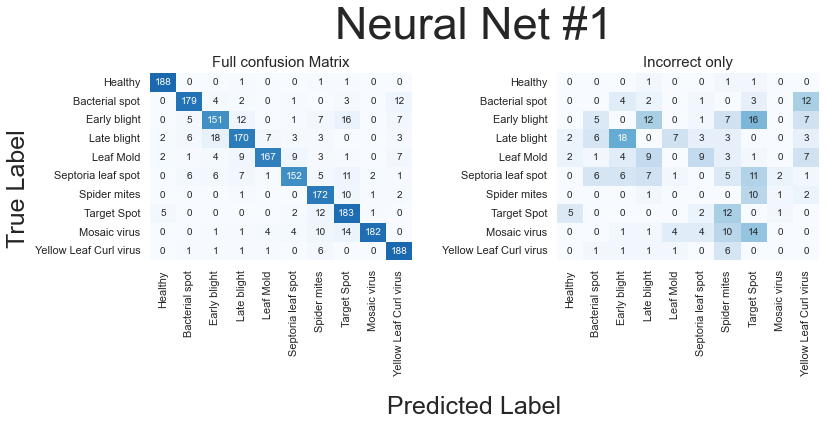

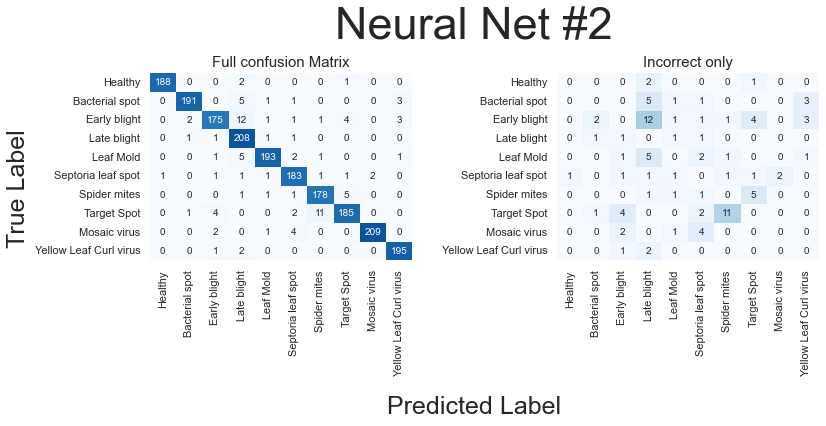

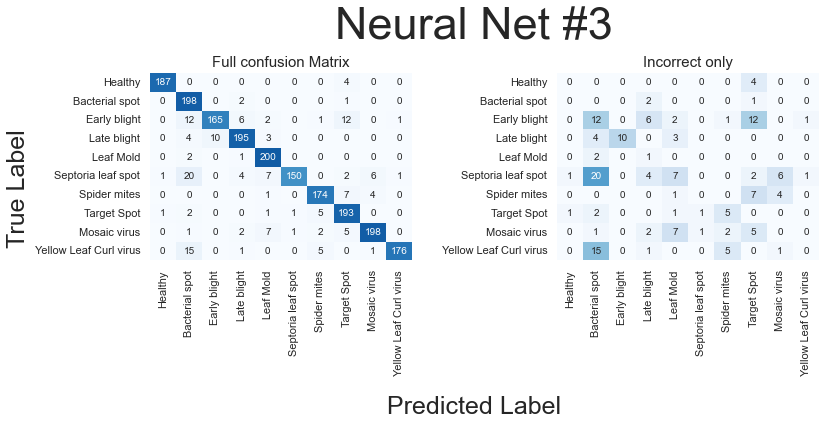

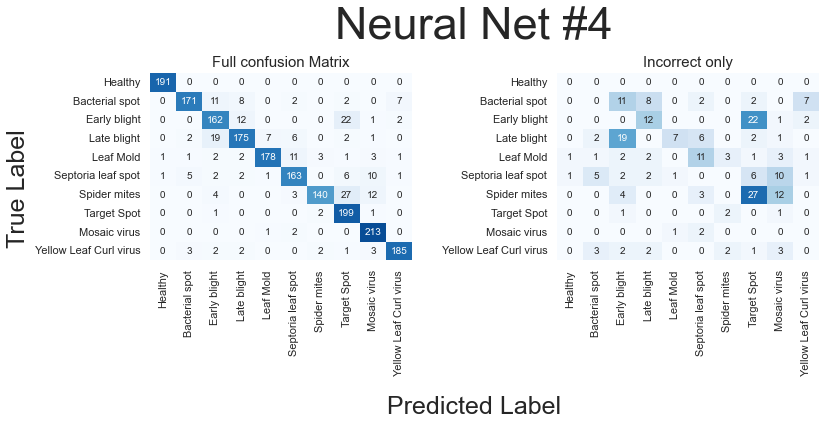

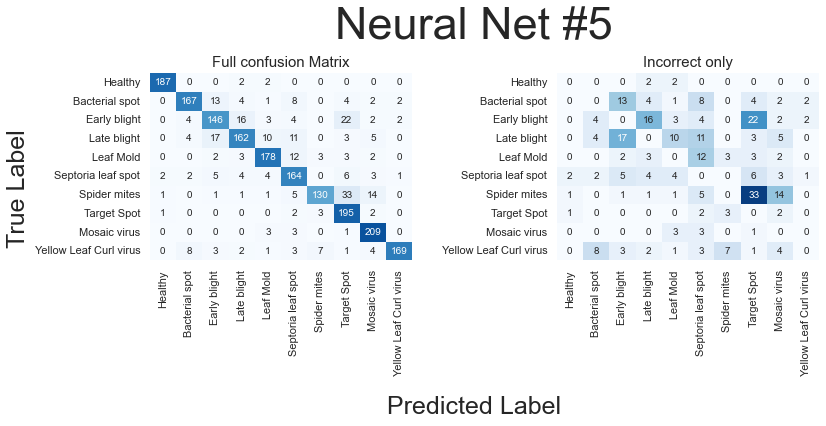

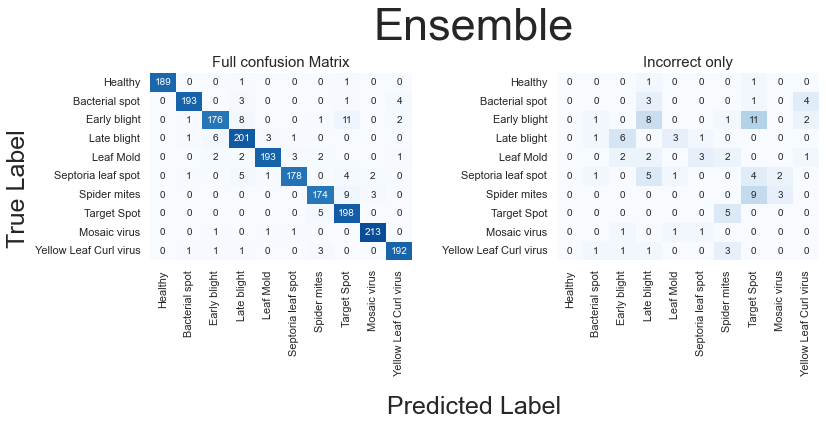

In [27]:
def show_confusion_matrices(confusion_list):
    for i_num, conf in enumerate(confusion_list):
        # Use a heatmap plot to display it.
        fig, (ax1, ax2) = plt.subplots(1, 2)

        sns.heatmap(conf, ax=ax1, annot=True, fmt='.3g', cmap='Blues',
                        xticklabels=[val for key, val in class_names.items()], 
                        yticklabels=[val for key, val in class_names.items()], 
                        cbar=False, vmin=0, vmax=240)

        diag = np.diag(np.diag(conf))
        failures = conf- diag
        sns.heatmap(failures, ax=ax2, annot=True, fmt='.3g', cmap='Blues',
                    xticklabels=[val for key, val in class_names.items()], 
                    yticklabels=[val for key, val in class_names.items()], 
                    cbar=False, vmin=0, vmax=35)

        title = f'Neural Net #{i_num+1}' if i_num < len(confusion_list)-1 else 'Ensemble'

        ax1.set_title("Full confusion Matrix", fontsize=15)
        ax2.set_title("Incorrect only", fontsize=15)
        
        plt.subplots_adjust(left=0.35,
                        bottom=.1, 
                        right=1.9, 
                        top=0.75, 
                        wspace=0.55, 
                        hspace=0.4)

        plt.gcf().suptitle(title, x=1.1, y=0.98, fontsize=45)
        fig.supxlabel('Predicted Label', fontsize=25, x=1.1, y=-.45)
        fig.supylabel('True Label', fontsize=25, y=0.35)
        
        plt.show()

show_confusion_matrices(ensemble_characterization_results['confusion_list'])

# 5. Characterization of final models

In [28]:
def get_n_worst_from_conf_matrix(confusion_matrix, num):
    diag = np.diag(np.diag(confusion_matrix))
    failures = confusion_matrix- diag
    x = tf.reshape(failures, (1, -1))
    indices_1d = tf.math.top_k(x, num)

    rows = (indices_1d[1] // confusion_matrix.shape[0]).numpy()
    cols = (indices_1d[1] % confusion_matrix.shape[0]).numpy()

    return [pt for pt in zip(rows[0],cols[0])]

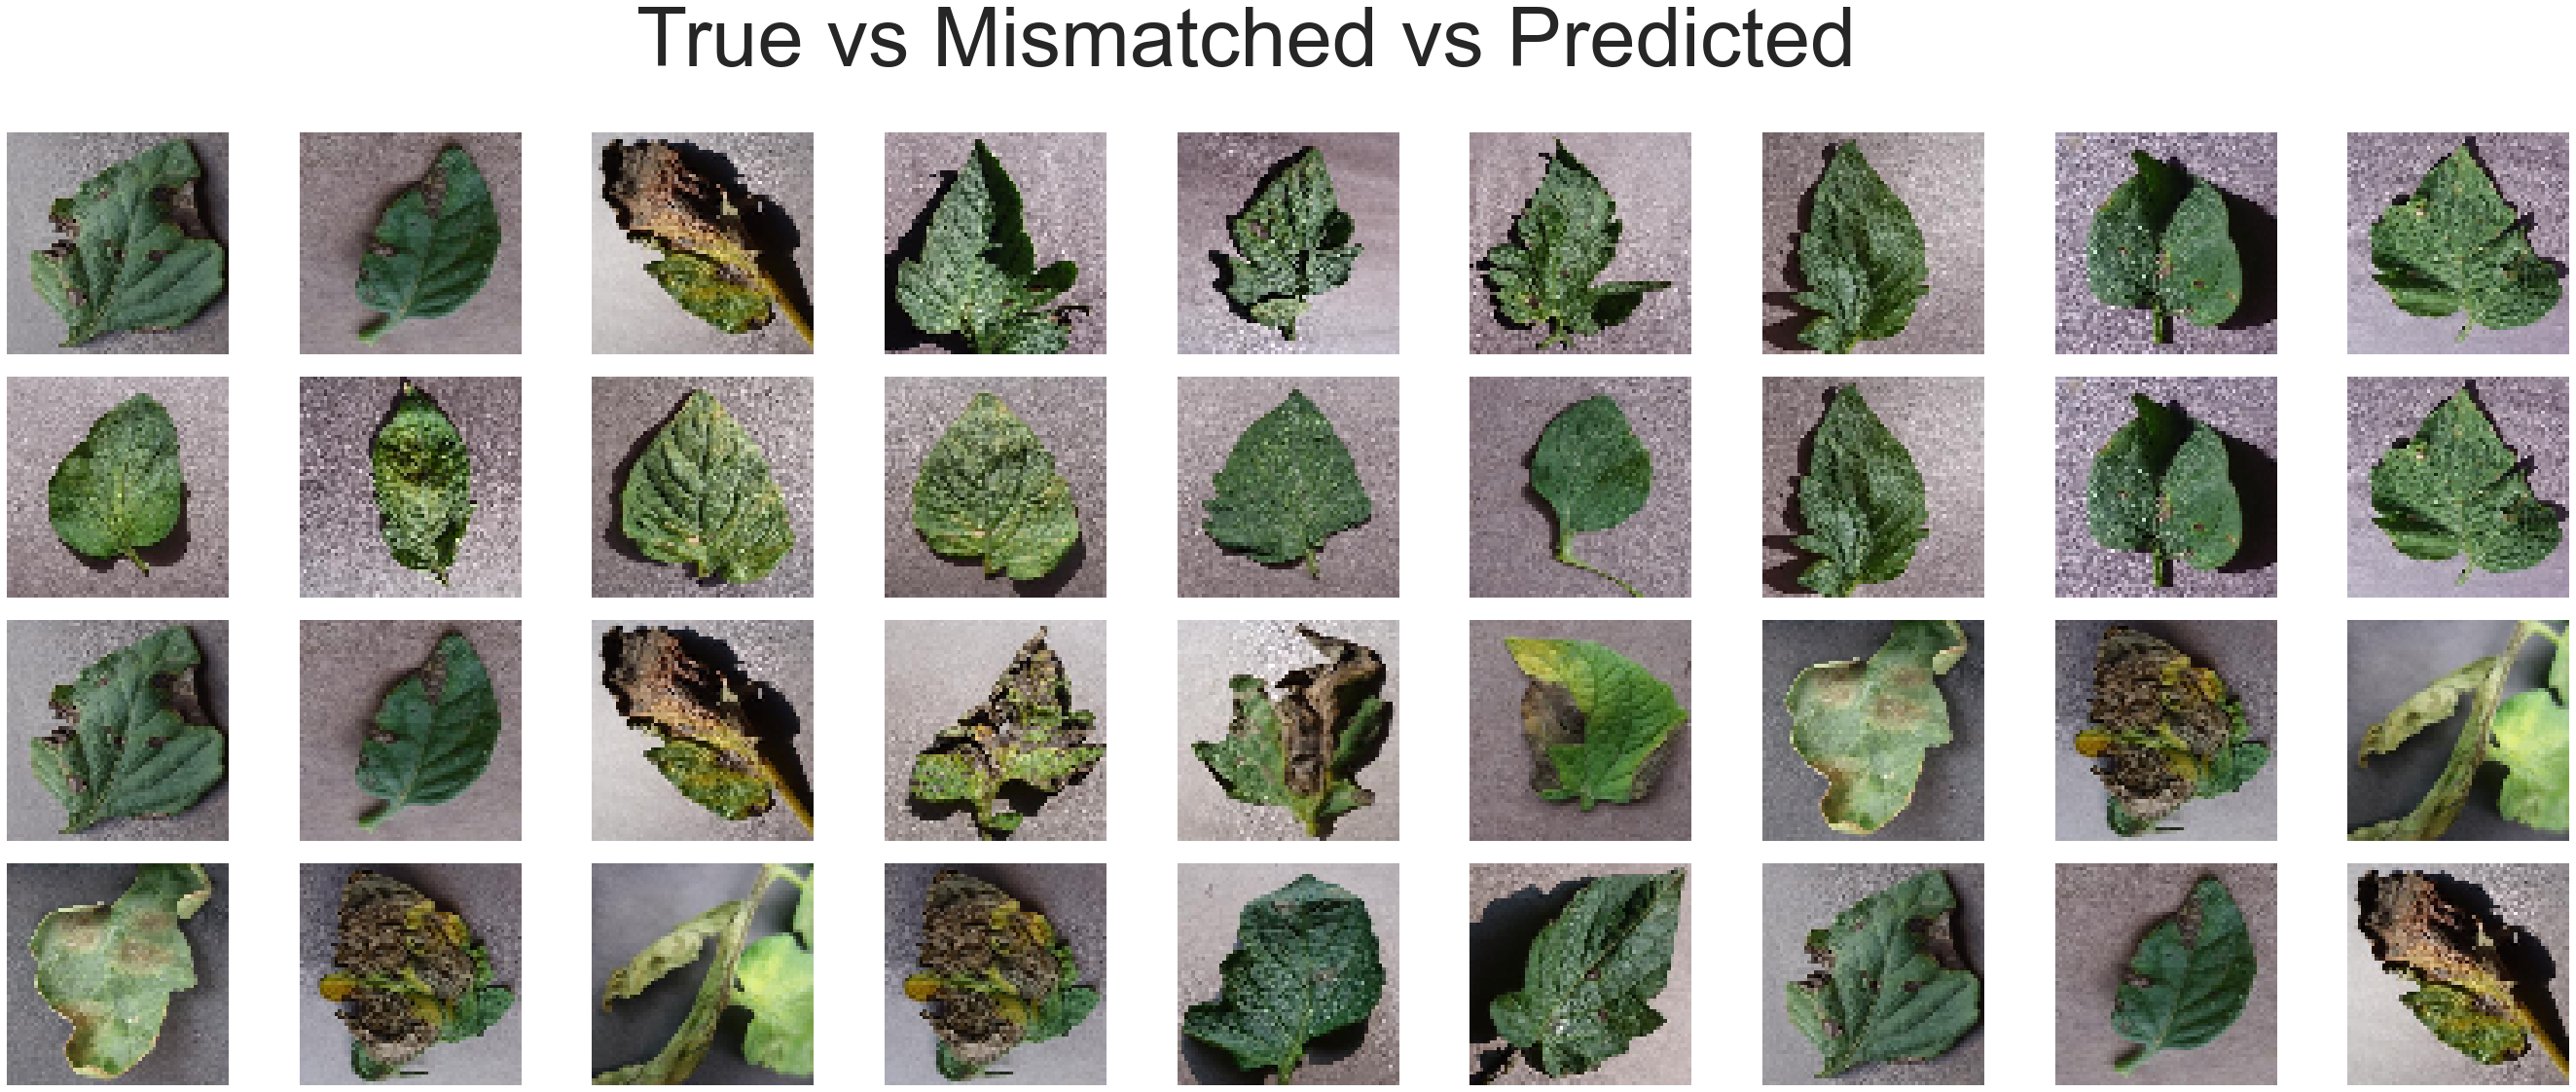

In [55]:
num_failed_categories = 4
num_examples = 3
worst_results = get_n_worst_from_conf_matrix(ensemble_characterization_results['confusion_list'][-1], num_failed_categories)

fig, axs = plt.subplots(nrows=num_failed_categories, ncols=3*num_examples, figsize=(48, 18))

for i in range(num_failed_categories):
    mismatch = worst_results[i]
    true_class = mismatch[0]
    pred_class = mismatch[1]

    # get {num_examples} images of the TRUE class
    true_images = X_test[y_test == true_class][:num_examples]
    for x in range(num_examples):
        axs[i, x].imshow(true_images[x])
        axs[i, x].axis('off')
        # axs[i, x].set_title("True: " + class_names[list(class_names)[true_class]], fontsize=21)

    # get {num_examples} images of the MISMATCHES
    mismatched_images = X_test[(y_test == mismatch[0]) & (ensemble_characterization_results['ensemble_decisions'] == mismatch[1])][:num_examples]
    # print(mismatched_images)
    for x in range(num_examples):
        # print(mismatched_images[x])
        axs[i, x + num_examples].imshow(mismatched_images[x])
        axs[i, x + num_examples].axis('off')
        # axs[i, x + num_examples].set_title(f"True:{class_names[list(class_names)[true_class]]}\nPred:{class_names[list(class_names)[pred_class]]}", fontsize=21)

    # get {num_examples} images of the PREDICTED class
    pred_images = X_test[(y_test == mismatch[1])][:num_examples]
    for x in range(num_examples):
        axs[i, x + 2*num_examples].imshow(pred_images[x])
        axs[i, x + 2*num_examples].axis('off')
        # axs[i, x + 2*num_examples].set_title("Pred: "+class_names[list(class_names)[true_class]], fontsize=21)

fig.suptitle("True vs Mismatched vs Predicted", fontsize=85)
# fig.tight_layout()

plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()

# 6. Characterization of Human Models


In [59]:
locs = r'C:\Users\jscot\OneDrive\Documents\school\W207\project\human_models'

def load_test_imgs(img_fold, img_size=IMG_SIZE):
    images = []
    for img_num, img_loc in enumerate(Path(img_fold).glob('*')):
        img = load_img(img_loc,
            target_size=img_size)
        img = img_to_array(img)
        images.append(img)

    images = np.stack(images)
    
    imgs_to_test = tf.image.resize(images, size=img_size)
    imgs_to_test = imgs_to_test/255.0
    return imgs_to_test

def use_ensemble_to_pred(ensemble_models_list, Xs_to_pred):
    totals = np.zeros(shape=(Xs_to_pred.shape[0], len(list(class_names))))

    for nn_num, nn in enumerate(ensemble_models_list):
        preds = nn.predict(Xs_to_pred)
        totals = totals + preds

    return totals

human_models = load_test_imgs(locs, (64, 64))
predicted_human_models = use_ensemble_to_pred(ensemble_models, human_models).argmax(axis=1)
predicted_human_models

array([3, 3, 3], dtype=int64)

# 7. Additional EDA

In [223]:
# if all are shrunk to 2x2 px images
# 1000 images in 10 classes

width_to_height = 1.78
num_imgs = 1000
img_height = 1
num_classes = 10

width_to_height_per_class = width_to_height / num_classes

height = math.ceil((num_imgs/width_to_height_per_class)**.5)
width = math.ceil(num_imgs / height)

save_loc = r'C:\Users\jscot\OneDrive\Documents\data\Plant Leaf Diseases\Plant_leaf_diseases_dataset_with_augmentation_mini'

# save a smaller version of the image to a folder
for img in list(mapping.iterrows()):
    img_loc = img[1][0]
    img_class = img[1][1]
    save_img = Path(save_loc) / f'{img_class}' / f"{img_loc.split('(')[1].split(')')[0]}.png"
    img = Image.open(img_loc)
    img = img.resize((img_height, img_height), resample=Image.LANCZOS)
    img.save(save_img)

new_img = np.zeros((height*img_height, width*num_classes*img_height, 3))

# go through and add each small image to a new_img Image
for class_num in range(num_classes):
    for img_x in range(width):
        for img_y in range(height):
            img_num = img_y + img_x*height
            if img_num >= 1000:
                break
            x_start = class_num*width*img_height+img_x*img_height
            x_end = class_num*width*img_height+(img_x+1)*img_height
            y_start = img_y*img_height
            y_end = (img_y+1)*img_height
            img_name_num = mapping[mapping.loc[:,'class'] == class_num].iloc[img_num].file_path.split('(')[1].split(')')[0]
            img_loc_small = Path(save_loc) / f'{class_num}' / f"{img_name_num}.png"            
            # print(img_y, img_x, img_num, class_num, f'y:({y_start},{y_end}) x:({x_start}, {x_end})', img_loc_small)
            img = np.asarray(Image.open(img_loc_small))
            new_img[y_start:y_end, x_start:x_end, :] = img

Image.fromarray(np.uint8(new_img)).save(r'C:\Users\jscot\OneDrive\Documents\school\W207\project\all_imgs_1px.png')
Image.fromarray(np.uint8(new_img)).show()